In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report,f1_score,confusion_matrix
from sklearn.pipeline import Pipeline  # Import Pipeline
from scipy.sparse import hstack, csr_matrix
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#############################################
# 1. Load & Inspect the Data
#############################################

In [3]:
data_file = "Artificial_Data.xlsx"
# Read data file
df = pd.read_excel(f"data/{data_file}")

# Display the first few rows and basic info
print("Data Head:")
print(df.head())
print("\nData Info:")
print(df.info())
print("\nData Description:")
print(df.describe())

Data Head:
  RATING_TYPE Rating  FundaIndxint  FundaIndxsga  monthvwretd  monthvwretx  \
0       Fitch     A+      0.150659     -0.420047    -0.846934     0.560226   
1     Moody's     BB     -0.015715      0.139204    -0.045250    -0.912128   
2       Fitch     BB     -1.330074      0.001814    -2.564342     0.997115   
3       Fitch    BBB     -0.025288      0.755935     1.142726    -0.235319   
4     Moody's     AA      1.343168      1.933543    -1.896747     0.467780   

   monthewretd  monthewretx  monthsprtrn  monthspindx  ...   at_turn  \
0     0.579303    -0.578314    -0.225006    -0.415867  ... -0.810215   
1     0.497292    -0.910558     1.207592    -0.104050  ...  1.201837   
2     0.762847    -0.870865     0.230487     0.515273  ...  0.578919   
3     0.637967    -1.611961     0.432309     1.194182  ... -0.067498   
4    -0.442432     1.349705     0.541002     0.096545  ...  0.795701   

   rect_turn  pay_turn  sale_invcap  sale_equity   rd_sale  adv_sale  \
0   0.308114 -0

In [4]:
# Display basic info
print("Data shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nAny Missing Data:",df.isnull().values.any())

Data shape: (100, 154)

Columns: ['RATING_TYPE', 'Rating', 'FundaIndxint', 'FundaIndxsga', 'monthvwretd', 'monthvwretx', 'monthewretd', 'monthewretx', 'monthsprtrn', 'monthspindx', 'monthCAP1RET', 'monthCAP2RET', 'monthCAP3RET', 'monthCAP4RET', 'monthCAP5RET', 'monthCAP6RET', 'monthCAP7RET', 'monthCAP8RET', 'monthCAP9RET', 'monthCAP10RET', 'monthtotval', 'monthtotcnt', 'monthusdval', 'monthusdcnt', 'monthprtcnt', 'monthtotret', 'monthtotind', 'monthcapret', 'monthcapind', 'monthincret', 'monthincind', 'SPIndvwretd', 'SPIndvwretx', 'SPIndewretd', 'SPIndewretx', 'SPIndtotval', 'SPIndtotcnt', 'SPIndusdval', 'SPIndusdcnt', 'SPIndspindx', 'SPIndsprtrn', 'SPporvwretd', 'SPporvwretx', 'SPporewretd', 'SPporewretx', 'SPportotval', 'SPportotcnt', 'SPporusdval', 'SPporusdcnt', 'SPporspindx', 'SPporsprtrn', 'usind2CRSPMEV1', 'usind2CRSPMEG1', 'usind2CRSPLCV1', 'usind2CRSPLCG1', 'usind2CRSPMIV1', 'usind2CRSPMIG1', 'usind2CRSPSCV1', 'usind2CRSPSCG1', 'usind2CRSPMEVT', 'usind2CRSPMEGT', 'usind2CRSPLC

#### The given dataset contains 100 rows and 154 columns, out of which 151 are numeric columns and 3 contains categorical and textual column.

#### Given Dataset does not have any missing values

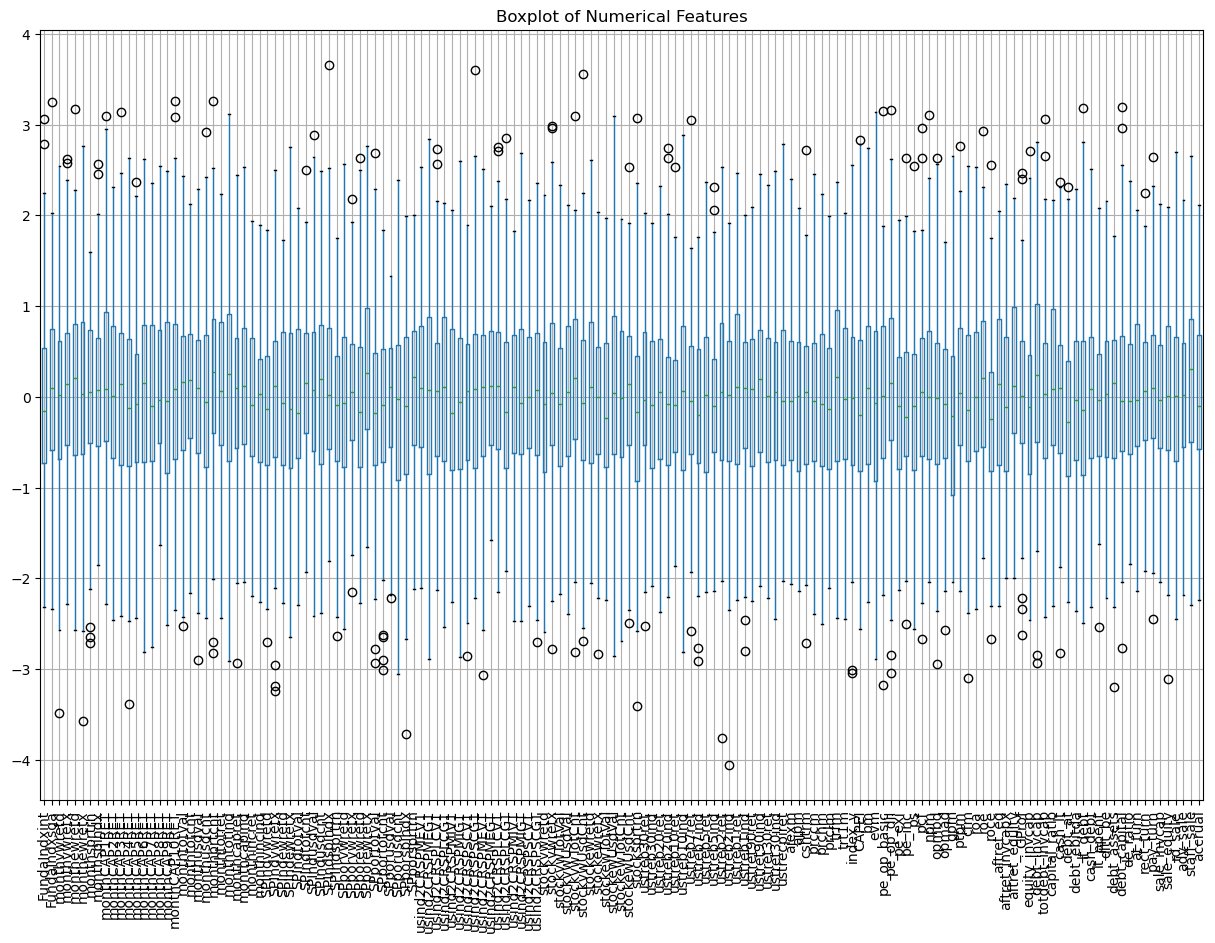

In [5]:
# Check for outliers in numerical features
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(15, 10))
df[num_cols].boxplot()
plt.xticks(rotation=90)
plt.title('Boxplot of Numerical Features')
plt.show()


#############################################
# 2. Data Cleaning and Preprocessing
#############################################

In [6]:
# A. Handling Missing Values for Numeric Features
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# B. Scaling numeric features
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# C. Encoding categorical variables:
# We will one-hot encode 'RATING_TYPE'
df = pd.get_dummies(df, columns=["RATING_TYPE"], drop_first=True)

# Get all generated one-hot encoded columns dynamically
one_hot_encoded_cols = [col for col in df.columns if col.startswith("RATING_TYPE_")]

#We will use label encoding for 'Rating'
le = LabelEncoder()
df['Rating_encoded'] = le.fit_transform(df['Rating'])

# Our target for classification will be 'Rating_encoded'
target = 'Rating_encoded'


#############################################
# 3. NLP Feature Engineering
#############################################

In [7]:
# Stopwords and Lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# A. Text Preprocessing Function
def clean_text(text):
    if pd.isnull(text):
        return ""
    # 1. Remove punctuation and numeric values using regex
    text = re.sub(r'[^\w\s]', '', text)

    # 2. Convert to lowercase
    text = text.lower()

    # 3. Tokenize the text (split into words)
    tokens = text.split()

    # 4. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # 5. Apply lemmatization (using WordNetLemmatizer)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a single string
    cleaned_text = " ".join(tokens)
    return cleaned_text

# Apply text cleaning on the 'string_values' column
df['clean_text'] = df['string_values'].apply(clean_text)

# B. Text Representation with TF-IDF
tfidf = TfidfVectorizer(max_features=500)  # Adjust max_features as needed
tfidf_features = tfidf.fit_transform(df['clean_text'])

# C. Sentiment Analysis using TextBlob
def get_sentiment(text):
    try:
        return TextBlob(text).sentiment.polarity
    except Exception as e:
        return 0.0

df['sentiment'] = df['clean_text'].apply(get_sentiment)

#############################################
# 4. Modeling
##### We will create three sets of features: structured-only, text-only, and combined.
#############################################

### Structure-Only Model

In [8]:
# Split data into features and target
structured_features = df[numeric_cols]
X_structured = structured_features.copy()
y = df[target]

# Split data for each model
X_train_struct, X_test_struct, y_train_struct, y_test_struct = train_test_split(X_structured, y, test_size=0.2, random_state=42,stratify=y)

# Random Forest Classifier
rfc_struct = RandomForestClassifier(random_state=42)

# Fit Random Forest model
rfc_struct.fit(X_train_struct, y_train_struct)
preds_struct = rfc_struct.predict(X_test_struct)  # Use encoded test set
accuracy = accuracy_score(y_test_struct, preds_struct)
print("Structured-Only Model Accuracy:",accuracy*100)
print("Classification Report (Structured):")
print(classification_report(y_test_struct, preds_struct))



Structured-Only Model Accuracy: 25.0
Classification Report (Structured):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.40      0.67      0.50         3
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.33      0.50      0.40         2
           6       0.25      0.50      0.33         4
           7       0.00      0.00      0.00         2

    accuracy                           0.25        20
   macro avg       0.12      0.21      0.15        20
weighted avg       0.14      0.25      0.18        20



### Text-Only Model

In [9]:
# Text-only features
sentiment_feature = csr_matrix(df['sentiment'].values.reshape(-1, 1))
# Select the one-hot encoded columns from the DataFrame
one_hot_encoded_features = csr_matrix(df[one_hot_encoded_cols].values)
X_text = hstack([tfidf_features,sentiment_feature, one_hot_encoded_features])

# Split data for each model
X_train_text, X_test_text,y_train_text, y_test_text = train_test_split(X_text, y, test_size=0.2, random_state=42)

# Fit Random Forest Classifier
rfc_text = RandomForestClassifier(random_state=42)
rfc_text.fit(X_train_text, y_train_text)
preds_text = rfc_text.predict(X_test_text)
accuracy = accuracy_score(y_test_text, preds_text)
print("\nText-Only Model Accuracy:", accuracy*100)
print("Classification Report (Text-Only):")
print(classification_report(y_test_text, preds_text))



Text-Only Model Accuracy: 20.0
Classification Report (Text-Only):
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       1.00      0.33      0.50         3
           2       0.00      0.00      0.00         2
           3       0.25      0.25      0.25         4
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.25      0.25      0.25         4
           7       0.00      0.00      0.00         2

    accuracy                           0.20        20
   macro avg       0.23      0.15      0.17        20
weighted avg       0.30      0.20      0.23        20



### Combined Model

In [10]:
# Combined model
X_combined = hstack([X_structured, X_text, tfidf_features])

# Split data for each model
X_train_comb, X_test_comb, y_train_comb, y_test_comb= train_test_split(X_combined, y, test_size=0.2, random_state=42,stratify=y)

# GradientBoostingClassifier on combined features
gbc_comb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
gbc_comb.fit(X_train_comb, y_train_comb)
preds_comb = gbc_comb.predict(X_test_comb)
accuracy = accuracy_score(y_test_comb, preds_comb)
print("\nCombined Model Accuracy on GradientBoosting:", accuracy*100)
print("Classification Report (Combined):")
print(classification_report(y_test_comb, preds_comb))


# RandomForestClassifier on combined features
rfc_comb = RandomForestClassifier(random_state=42)
rfc_comb.fit(X_train_comb, y_train_comb)
preds_comb = rfc_comb.predict(X_test_comb)
accuracy = accuracy_score(y_test_comb, preds_comb)
print("\nCombined Model Accuracy on Random Forest:", accuracy*100)
print("Classification Report (Combined):")
print(classification_report(y_test_comb, preds_comb))


Combined Model Accuracy on GradientBoosting: 15.0
Classification Report (Combined):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.75      1.00      0.86         3
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         2

    accuracy                           0.15        20
   macro avg       0.09      0.12      0.11        20
weighted avg       0.11      0.15      0.13        20


Combined Model Accuracy on Random Forest: 25.0
Classification Report (Combined):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      0.33      0.33         3
           2       

##### Here we can see on Random Forest Classifier we get 25% accuracy, so we choose Random Forest for hyperparameter tunning

#############################################
# Model Accuracy Comparison
#############################################

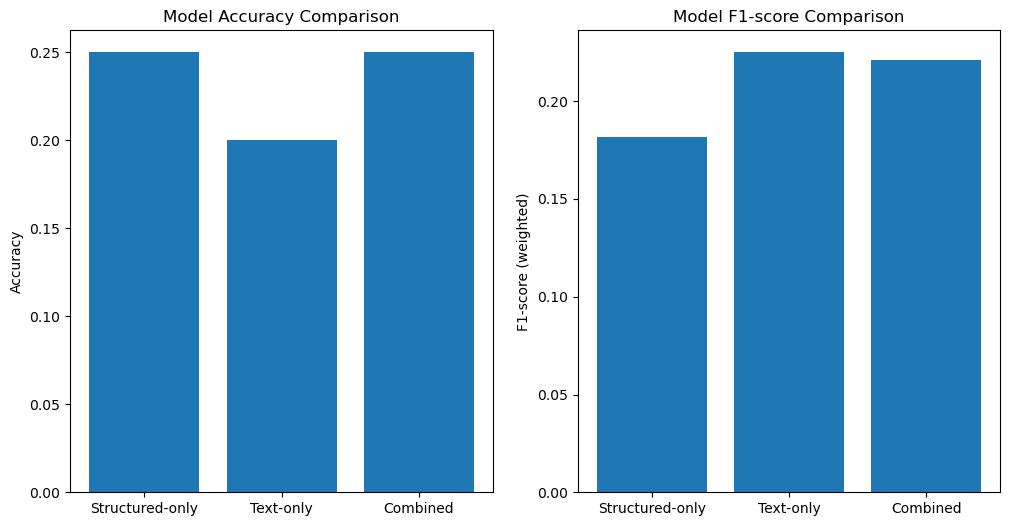

In [11]:
# Compare model performances
models = ['Structured-only', 'Text-only', 'Combined']
accuracies = [
    accuracy_score(y_test_struct, preds_struct),
    accuracy_score(y_test_text, preds_text),
    accuracy_score(y_test_comb, preds_comb)
]
f1_scores = [
    f1_score(y_test_struct, preds_struct, average='weighted'),
    f1_score(y_test_text, preds_text, average='weighted'),
    f1_score(y_test_comb, preds_comb, average='weighted')
]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(models, accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.bar(models, f1_scores)
plt.title('Model F1-score Comparison')
plt.ylabel('F1-score (weighted)')
plt.show()

#############################################
# 6. Hyperparameter tunning using GridSearchCV of Structured-Only model
#############################################

In [12]:
# Define parameter grid
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

# Define a parameter grid to search over.
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [5, 10, 15, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV to optimize the parameters using cross-validation.
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_struct, y_train_struct)

# Get the best model from the grid search.
best_model = grid_search.best_estimator_

# Make predictions on the test set.
y_pred = best_model.predict(X_test_struct)

# Calculate accuracy.
accuracy = accuracy_score(y_test_struct, y_pred)

# classification report.
report = classification_report(y_test_struct, y_pred)

# confusion matrix.
conf_matrix = confusion_matrix(y_test_struct, y_pred)

# Print the results.
print("Best Hyperparameters:\n", grid_search.best_params_)
print("\nTest Accuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)


Best Hyperparameters:
 {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}

Test Accuracy: 10.00%

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.00      0.00      0.00         3
           2       0.20      0.33      0.25         3
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         2

    accuracy                           0.10        20
   macro avg       0.09      0.10      0.09        20
weighted avg       0.08      0.10      0.09        20

Confusion Matrix:
 [[1 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 2 0]
 [0 0 1 0 0 0 2 0]
 [0 1 0 0 0 0 1 0]
 [0 0 2 0 0 0 0 0]
 [1 0 0 0 0 0 1 0]
 [0 1 2 0 0 0 0 1]
 [0 0 0 0 0 1 1 0]]


#############################################
# 6. Interpretation using SHAP (for Structured Model)
#############################################

<Figure size 640x480 with 0 Axes>

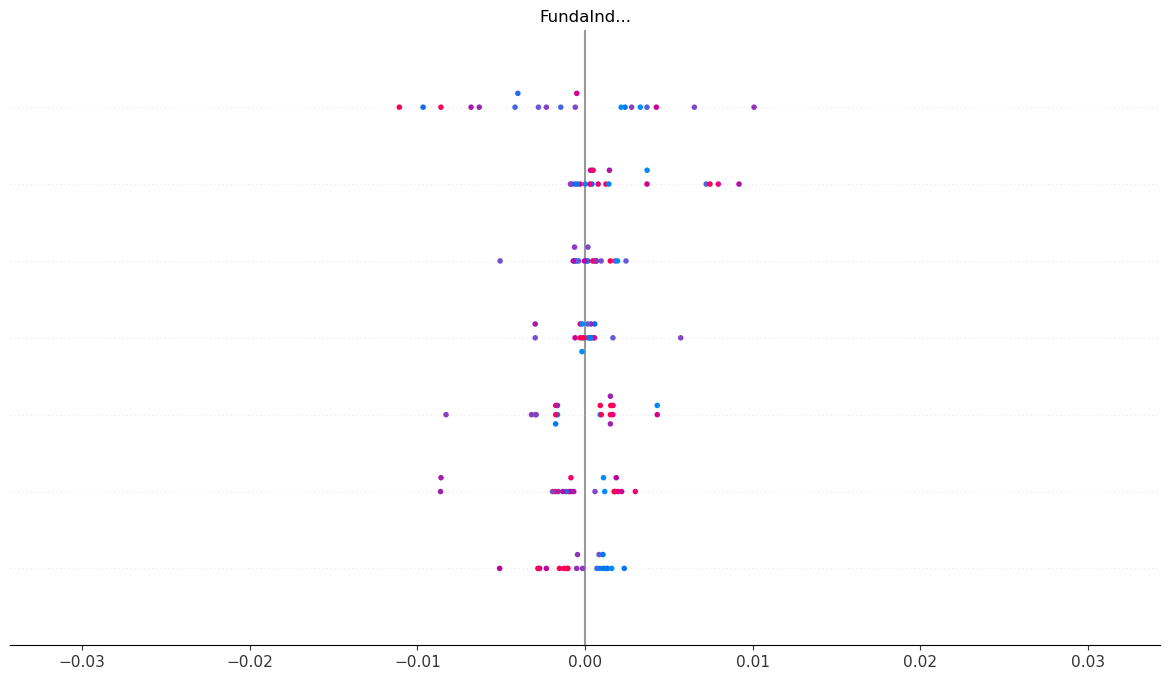

In [13]:
# Calculate SHAP values for the structured-only model
explainer = shap.TreeExplainer(rfc_struct)
shap_values = explainer.shap_values(X_test_struct)
# Plot summary of feature importances
shap.summary_plot(shap_values, X_test_struct, feature_names=X_test_struct.columns)

<Figure size 640x480 with 0 Axes>

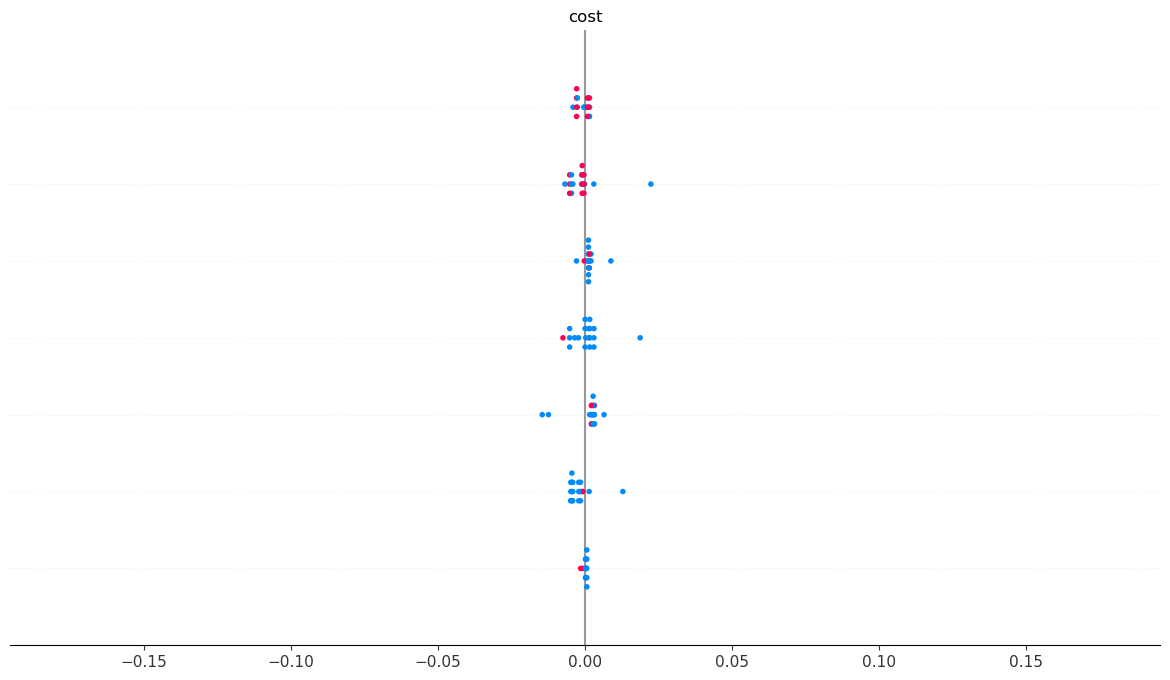

In [14]:
# Calculate SHAP values for the text-only model
explainer = shap.TreeExplainer(rfc_text)
# Convert X_test_text to a dense NumPy array with numeric dtype
X_test_text_dense = X_test_text.toarray().astype(np.float64)
shap_values = explainer.shap_values(X_test_text_dense)
# Plot summary of feature importances
shap.summary_plot(shap_values, X_test_text_dense, feature_names=tfidf.get_feature_names_out()) # Assuming tfidf is your TfidfVectorizer

<Figure size 640x480 with 0 Axes>

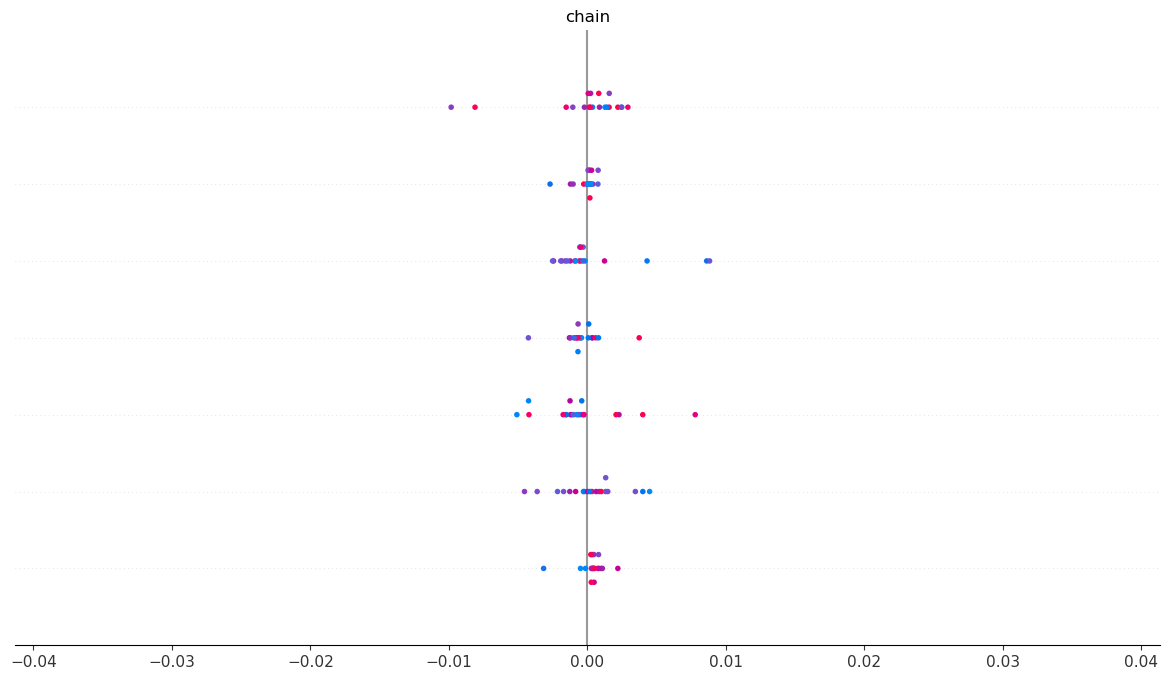

In [15]:
# Calculate SHAP values for the Combined model
explainer = shap.TreeExplainer(rfc_comb)
# Convert X_test_comb to a dense NumPy array with numeric dtype
X_test_comb_dense = X_test_comb.toarray().astype(np.float64)
shap_values = explainer.shap_values(X_test_comb_dense)
# Plot summary of feature importances
shap.summary_plot(shap_values, X_test_comb_dense, feature_names=tfidf.get_feature_names_out())

#############################################
# Topic Modeling
#############################################

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Extract text data for low-rated reviews
low_rating_reviews = df[df['Rating_encoded'] <= 2]['clean_text']



# Topic modeling using LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_features)

# Display top words for each topic
feature_names = tfidf.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
    print(f"Topic {topic_idx+1}: {', '.join(top_words)}")


Topic 1: chain, remain, logistics, improving, efficiency, investment, supply, strategic, challenge, market
Topic 2: year, last, tax, cost, driven, earnings, significantly, measure, reduction, improved
Topic 3: market, strong, company, increase, steady, demand, revenue, reported, reflecting, level
Topic 4: positive, remains, international, expected, outlook, domestic, growth, market, strong, revenue
Topic 5: reported, reflecting, increase, steady, demand, revenue, company, strong, market, volatility


#############################################
# 7. Visualizations for NLP Insights
#############################################

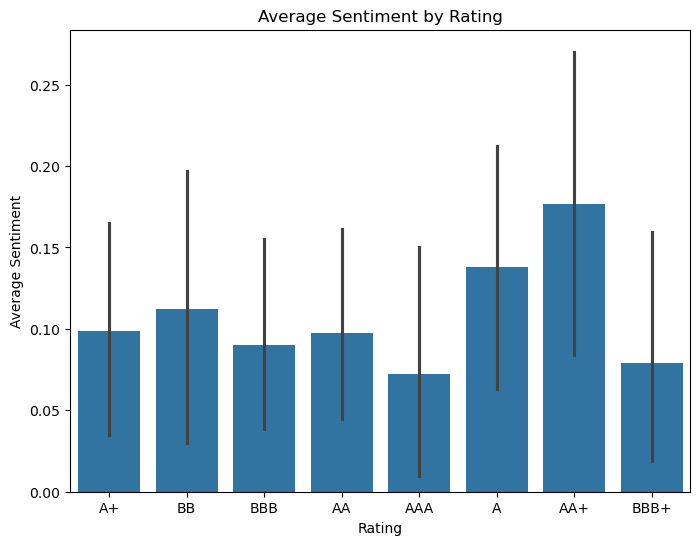

In [17]:
# Plot average sentiment by actual rating label
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.barplot(x=df['Rating'], y=df['sentiment'])
plt.title("Average Sentiment by Rating")
plt.xlabel("Rating")
plt.ylabel("Average Sentiment")
plt.show()

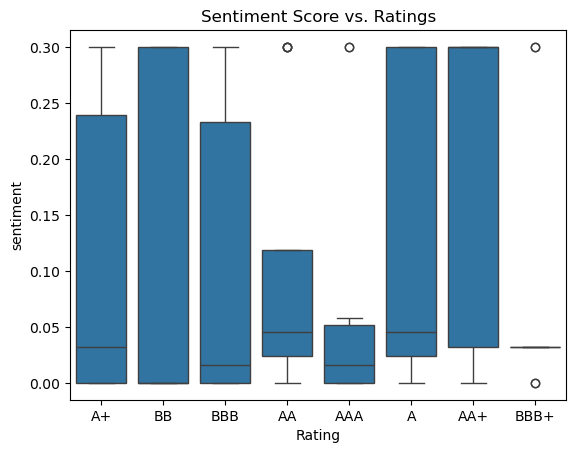

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizing sentiment vs. rating
sns.boxplot(x=df["Rating"], y=df["sentiment"])
plt.title("Sentiment Score vs. Ratings")
plt.show()